### Descriptive and comparative analysis of IgA measures

This notebook explores different strategies to compare IgA measures using different categorical values for Attachment and Gender.

Specifically, this notebook implements:

- Reading and cleaning input data
- Remove non-relevant columns
- Plot distributions of IgA by Attachment and Gender using boxplots and violin plots
- Statistical comparison for IgA measures by U-test and kruskal with Dunn test
- Estimating Cliffs for detecting differences between distributions
- Estimating Rank biserial
- Exploring clustering strategies for pattern generation

- Handling modules

In [53]:
import warnings
warnings.filterwarnings("ignore")

- Loading modules

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from scipy.stats import kruskal
from typing import Tuple

- Auxiliar functions

In [68]:
def classify_iga_level(avg):
    if avg > 100:
        return "High IgA"
    elif avg < 30:
        return "Low IgA"
    else:
        return "Moderate IgA"

In [54]:
def rank_biserial_correlation(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute rank-biserial correlation from two independent samples.
    """
    from scipy.stats import mannwhitneyu

    nx = len(x)
    ny = len(y)

    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    rbc = 1 - (2 * U) / (nx * ny)

    abs_rbc = abs(rbc)
    if abs_rbc < 0.1:
        interpretation = "negligible"
    elif abs_rbc < 0.3:
        interpretation = "small"
    elif abs_rbc < 0.5:
        interpretation = "medium"
    else:
        interpretation = "large"

    return rbc, interpretation

In [44]:
def cliffs_delta(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute Cliff's Delta and return interpretation.
    """
    nx = len(x)
    ny = len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (nx * ny)

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        interpretation = "negligible"
    elif abs_delta < 0.33:
        interpretation = "small"
    elif abs_delta < 0.474:
        interpretation = "medium"
    else:
        interpretation = "large"
    return delta, interpretation

-Loading data

In [3]:
df_data = pd.read_csv("../processed_data/1_processed_data.csv")
df_data.head(5)

,ID,Attachment,Gender,IgA D1-Morning,IgA D1-Afternoon,IgA D2-Morning,IgA D2-Afternoon,Average IgA Morning,Average IgA Afternoon,Average Difference IgA
0,1,Insecure,Male,20.076728,31.719207,23.453752,25.016903,21.765240,28.368055,6.602815
1,4,Secure,Male,28.584920,82.400761,28.361209,19.363161,28.473065,50.881961,22.408896
2,5,Secure,Female,161.424693,46.867951,39.006348,52.728307,100.215520,49.798129,-50.417391
3,7,Insecure,Female,26.747838,47.213491,21.599136,35.942378,24.173487,41.577934,17.404447
4,11,NaN,Male,118.901337,47.213491,37.125222,382.715268,78.013279,214.964380,136.951100


In [5]:
df_data.shape

(35, 10)

In [4]:
df_data["Attachment"].value_counts()

Secure      18
Insecure     9
Name: Attachment, dtype: int64

- Cleaning and removing null data

In [6]:
df_data_clean = df_data.dropna()
df_data_clean.shape

(27, 10)

In [8]:
df_data_clean = df_data_clean[["ID", "Attachment", "Gender", "Average IgA Morning",
                               "Average IgA Afternoon", "Average Difference IgA"]]
df_data_clean.head(5)

,ID,Attachment,Gender,Average IgA Morning,Average IgA Afternoon,Average Difference IgA
0,1,Insecure,Male,21.765240,28.368055,6.602815
1,4,Secure,Male,28.473065,50.881961,22.408896
2,5,Secure,Female,100.215520,49.798129,-50.417391
3,7,Insecure,Female,24.173487,41.577934,17.404447
5,12,Secure,Female,29.554870,45.078186,15.523316


- Data visualization, boxplots and violinpolots

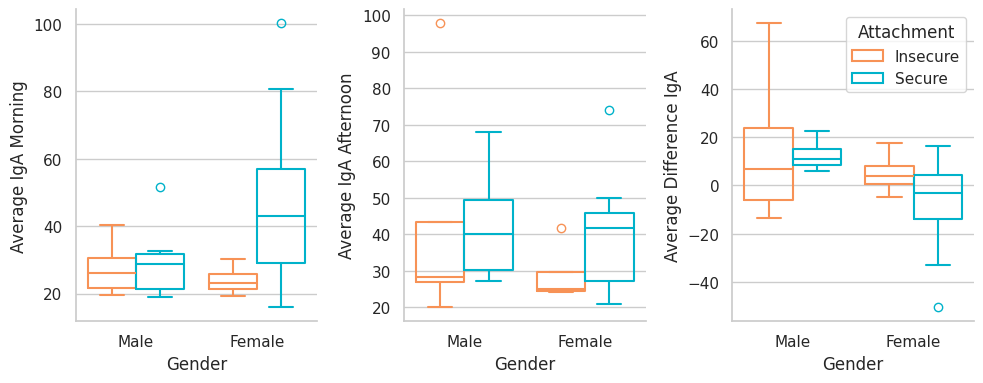

In [29]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data_clean, 
    y="Average IgA Morning", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.boxplot(
    data=df_data_clean, 
    y="Average IgA Afternoon", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data_clean, 
    y="Average Difference IgA", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()


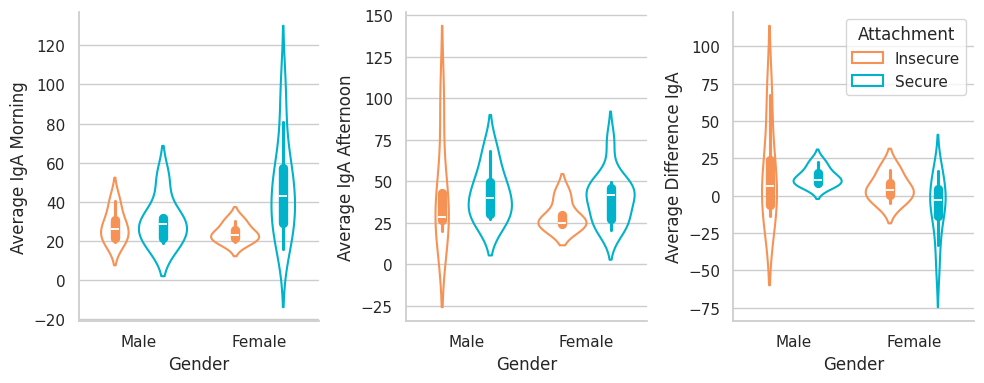

In [42]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.violinplot(
    data=df_data_clean, 
    y="Average IgA Morning", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.violinplot(
    data=df_data_clean, 
    y="Average IgA Afternoon", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.violinplot(
    data=df_data_clean, 
    y="Average Difference IgA", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()


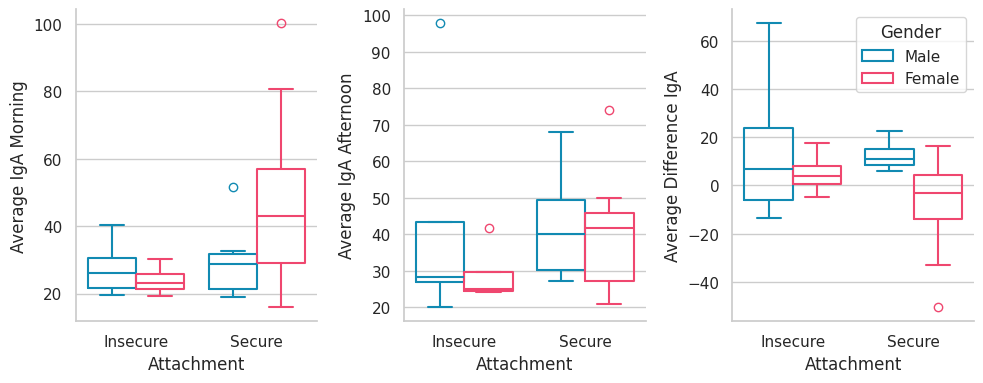

In [31]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Male": "#118AB2", "Female": "#EF476F"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data_clean, 
    y="Average IgA Morning", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.boxplot(
    data=df_data_clean, 
    y="Average IgA Afternoon", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data_clean, 
    y="Average Difference IgA", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

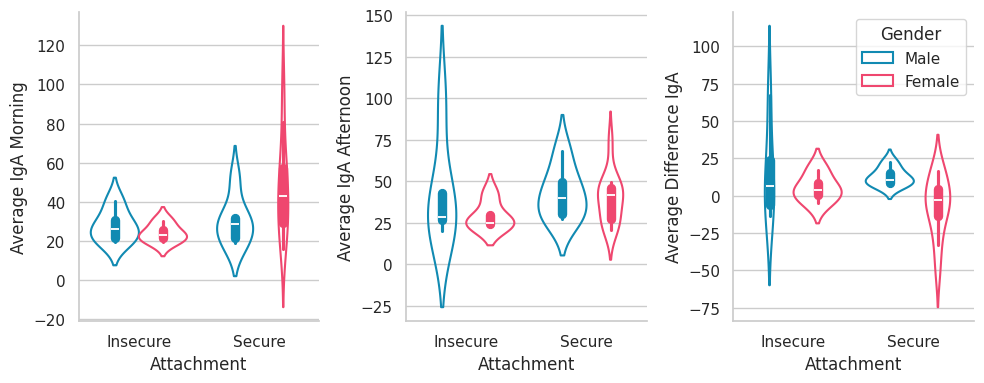

In [41]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Male": "#118AB2", "Female": "#EF476F"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.violinplot(
    data=df_data_clean, 
    y="Average IgA Morning", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.violinplot(
    data=df_data_clean, 
    y="Average IgA Afternoon", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.violinplot(
    data=df_data_clean, 
    y="Average Difference IgA", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

- U-test and Kruskal comparison

In [35]:
iga_vars = ["Average IgA Morning", "Average IgA Afternoon", "Average Difference IgA"]

gender_results = []
for var in iga_vars:
    male_vals = df_data_clean[df_data_clean["Gender"] == "Male"][var]
    female_vals = df_data_clean[df_data_clean["Gender"] == "Female"][var]
    stat, p = mannwhitneyu(male_vals, female_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    gender_results.append(statistic_result)

gender_results = pd.DataFrame(gender_results)
gender_results["reject"] = gender_results["p-value"]<=0.05
gender_results

,variable,U statistic,p-value,reject
0,Average IgA Morning,60.0,0.174773,False
1,Average IgA Afternoon,102.0,0.505299,False
2,Average Difference IgA,130.0,0.040572,True


In [37]:
attachment_results = []
for var in iga_vars:
    secure_vals = df_data_clean[df_data_clean["Attachment"] == "Secure"][var]
    insecure_vals = df_data_clean[df_data_clean["Attachment"] == "Insecure"][var]
    stat, p = mannwhitneyu(secure_vals, insecure_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    attachment_results.append(statistic_result)

attachment_results = pd.DataFrame(attachment_results)
attachment_results["reject"] = attachment_results["p-value"]<=0.05
attachment_results

,variable,U statistic,p-value,reject
0,Average IgA Morning,116.0,0.075982,False
1,Average IgA Afternoon,109.0,0.157231,False
2,Average Difference IgA,68.0,0.520269,False


In [40]:
df_data_clean["Group"] = df_data_clean["Attachment"] + " - " + df_data_clean["Gender"]

iga_vars = [
    "Average IgA Morning",
    "Average IgA Afternoon",
    "Average Difference IgA"
]

kruskal_results = {}
for var in iga_vars:
    data = [group[var].values for name, group in df_data_clean.groupby("Group")]
    stat, p = kruskal(*data)
    kruskal_results[var] = {"H statistic": stat, "p-value": p}
kruskal_df = pd.DataFrame(kruskal_results).T

print("=== Kruskal–Wallis Results ===")
print(kruskal_df)

# Post-hoc Dunn test with Holm correction
print("\n=== Dunn's Test (Holm-corrected p-values) ===")
for var in iga_vars:
    print(f"\n--- {var} ---")
    posthoc = sp.posthoc_dunn(
        df_data_clean,
        val_col=var,
        group_col="Group",
        p_adjust='holm'
    )
    print(posthoc)

=== Kruskal–Wallis Results ===
                        H statistic   p-value
Average IgA Morning        6.066667  0.108411
Average IgA Afternoon      3.240741  0.355976
Average Difference IgA     5.740741  0.124928

=== Dunn's Test (Holm-corrected p-values) ===

--- Average IgA Morning ---
                   Insecure - Female  Insecure - Male  Secure - Female  \
Insecure - Female           1.000000         1.000000         0.250081   
Insecure - Male             1.000000         1.000000         0.516332   
Secure - Female             0.250081         0.516332         1.000000   
Secure - Male               1.000000         1.000000         0.516332   

                   Secure - Male  
Insecure - Female       1.000000  
Insecure - Male         1.000000  
Secure - Female         0.516332  
Secure - Male           1.000000  

--- Average IgA Afternoon ---
                   Insecure - Female  Insecure - Male  Secure - Female  \
Insecure - Female           1.000000              1.0     

- Cliffs estimation

In [48]:
gender_cliffs = []
for var in iga_vars:
    male = df_data_clean[df_data_clean["Gender"] == "Male"][var]
    female = df_data_clean[df_data_clean["Gender"] == "Female"][var]
    delta, interp = cliffs_delta(male, female)
    gender_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

gender_cliffs = pd.DataFrame(gender_cliffs)
gender_cliffs

,variable,Cliff's Delta,Interpretation
0,Average IgA Morning,-0.318182,small
1,Average IgA Afternoon,0.159091,small
2,Average Difference IgA,0.477273,large


In [50]:
attachment_cliffs = []
for var in iga_vars:
    secure = df_data_clean[df_data_clean["Attachment"] == "Secure"][var]
    insecure = df_data_clean[df_data_clean["Attachment"] == "Insecure"][var]
    delta, interp = cliffs_delta(insecure, secure)
    attachment_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

attachment_cliffs = pd.DataFrame(attachment_cliffs)
attachment_cliffs

,variable,Cliff's Delta,Interpretation
0,Average IgA Morning,-0.432099,medium
1,Average IgA Afternoon,-0.345679,medium
2,Average Difference IgA,0.160494,small


In [52]:
combined_cliffs = {}
grouped = df_data_clean.groupby(["Attachment", "Gender"])
groups = list(grouped.groups.keys())

if len(groups) >= 2:
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            label = f"{g1} vs {g2}"
            results = {}
            for var in iga_vars:
                data1 = grouped.get_group(g1)[var]
                data2 = grouped.get_group(g2)[var]
                if len(data1) > 0 and len(data2) > 0:
                    delta, interp = cliffs_delta(data1, data2)
                    results[var] = {"Cliff's Delta": delta, "Interpretation": interp}
            combined_cliffs[label] = results

combined_cliffs_df = pd.concat({k: pd.DataFrame(v).T for k, v in combined_cliffs.items()}, names=["Group Comparison", "Variable"])
combined_cliffs_df

Cliff's Delta  \
Group Comparison                               Variable                               
('Insecure', 'Female') vs ('Insecure', 'Male') Average IgA Morning             -0.3   
                                               Average IgA Afternoon           -0.4   
                                               Average Difference IgA          -0.1   
('Insecure', 'Female') vs ('Secure', 'Female') Average IgA Morning        -0.666667   
                                               Average IgA Afternoon      -0.416667   
                                               Average Difference IgA      0.458333   
('Insecure', 'Female') vs ('Secure', 'Male')   Average IgA Morning        -0.166667   
                                               Average IgA Afternoon          -0.75   
                                               Average Difference IgA     -0.583333   
('Insecure', 'Male') vs ('Secure', 'Female')   Average IgA Morning        -0.566667   
                                               Average IgA Afternoon      -0.133333   
                                               Average Difference IgA      0.366667   
('Insecure', 'Male') vs ('Secure', 'Male')     Average IgA Morning              0.0   
                                               Average IgA Afternoon      -0.333333   
                                               Average Difference IgA     -0.133333   
('Secure', 'Female') vs ('Secure', 'Male')     Average IgA Morning         0.444444   
                                               Average IgA Afternoon      -0.138889   
                                               Average Difference IgA     -0.638889   

                                                                      Interpretation  
Group Comparison                               Variable                               
('Insecure', 'Female') vs ('Insecure', 'Male') Average IgA Morning             small  
                                               Average IgA Afternoon          medium  
                                               Average Difference IgA     negligible  
('Insecure', 'Female') vs ('Secure', 'Female') Average IgA Morning             large  
                                               Average IgA Afternoon          medium  
                                               Average Difference IgA         medium  
('Insecure', 'Female') vs ('Secure', 'Male')   Average IgA Morning             small  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          large  
('Insecure', 'Male') vs ('Secure', 'Female')   Average IgA Morning             large  
                                               Average IgA Afternoon      negligible  
                                               Average Difference IgA         medium  
('Insecure', 'Male') vs ('Secure', 'Male')     Average IgA Morning        negligible  
                                               Average IgA Afternoon          medium  
                                               Average Difference IgA     negligible  
('Secure', 'Female') vs ('Secure', 'Male')     Average IgA Morning            medium  
                                               Average IgA Afternoon      negligible  
                                               Average Difference IgA          large

- RBC estimation 

In [55]:
rbc_gender = []
for var in iga_vars:
    male = df_data_clean[df_data_clean["Gender"] == "Male"][var]
    female = df_data_clean[df_data_clean["Gender"] == "Female"][var]
    rbc, interp = rank_biserial_correlation(male, female)
    rbc_gender.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_gender = pd.DataFrame(rbc_gender)
rbc_gender

,variable,Rank-Biserial Corr,Interpretation
0,Average IgA Morning,0.318182,medium
1,Average IgA Afternoon,-0.159091,small
2,Average Difference IgA,-0.477273,medium


In [56]:
rbc_attachment = []
for var in iga_vars:
    secure = df_data_clean[df_data_clean["Attachment"] == "Secure"][var]
    insecure = df_data_clean[df_data_clean["Attachment"] == "Insecure"][var]
    rbc, interp = rank_biserial_correlation(secure, insecure)
    rbc_attachment.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_attachment = pd.DataFrame(rbc_attachment)
rbc_attachment

,variable,Rank-Biserial Corr,Interpretation
0,Average IgA Morning,-0.432099,medium
1,Average IgA Afternoon,-0.345679,medium
2,Average Difference IgA,0.160494,small


- Merge all comparisons

In [57]:
rbc_combined = {}
grouped = df_data_clean.groupby(["Attachment", "Gender"])
groups = list(grouped.groups.keys())

if len(groups) >= 2:
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            label = f"{g1} vs {g2}"
            results = {}
            for var in iga_vars:
                data1 = grouped.get_group(g1)[var]
                data2 = grouped.get_group(g2)[var]
                if len(data1) > 0 and len(data2) > 0:
                    rbc, interp = rank_biserial_correlation(data1, data2)
                    results[var] = {"Rank-Biserial Corr": rbc, "Interpretation": interp}
            rbc_combined[label] = results

rbc_combined_df = pd.concat({k: pd.DataFrame(v).T for k, v in rbc_combined.items()}, names=["Group Comparison", "Variable"])
rbc_combined_df

Rank-Biserial Corr  \
Group Comparison                               Variable                                    
('Insecure', 'Female') vs ('Insecure', 'Male') Average IgA Morning                   0.3   
                                               Average IgA Afternoon                 0.4   
                                               Average Difference IgA                0.1   
('Insecure', 'Female') vs ('Secure', 'Female') Average IgA Morning              0.666667   
                                               Average IgA Afternoon            0.416667   
                                               Average Difference IgA          -0.458333   
('Insecure', 'Female') vs ('Secure', 'Male')   Average IgA Morning              0.166667   
                                               Average IgA Afternoon                0.75   
                                               Average Difference IgA           0.583333   
('Insecure', 'Male') vs ('Secure', 'Female')   Average IgA Morning              0.566667   
                                               Average IgA Afternoon            0.133333   
                                               Average Difference IgA          -0.366667   
('Insecure', 'Male') vs ('Secure', 'Male')     Average IgA Morning                   0.0   
                                               Average IgA Afternoon            0.333333   
                                               Average Difference IgA           0.133333   
('Secure', 'Female') vs ('Secure', 'Male')     Average IgA Morning             -0.444444   
                                               Average IgA Afternoon            0.138889   
                                               Average Difference IgA           0.638889   

                                                                      Interpretation  
Group Comparison                               Variable                               
('Insecure', 'Female') vs ('Insecure', 'Male') Average IgA Morning            medium  
                                               Average IgA Afternoon          medium  
                                               Average Difference IgA     negligible  
('Insecure', 'Female') vs ('Secure', 'Female') Average IgA Morning             large  
                                               Average IgA Afternoon          medium  
                                               Average Difference IgA         medium  
('Insecure', 'Female') vs ('Secure', 'Male')   Average IgA Morning             small  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          large  
('Insecure', 'Male') vs ('Secure', 'Female')   Average IgA Morning             large  
                                               Average IgA Afternoon           small  
                                               Average Difference IgA         medium  
('Insecure', 'Male') vs ('Secure', 'Male')     Average IgA Morning        negligible  
                                               Average IgA Afternoon          medium  
                                               Average Difference IgA          small  
('Secure', 'Female') vs ('Secure', 'Male')     Average IgA Morning            medium  
                                               Average IgA Afternoon           small  
                                               Average Difference IgA          large

- Merge comparisons

In [58]:
gender_results.merge(right=gender_cliffs, on="variable").merge(right=rbc_gender, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,Average IgA Morning,60.0,0.174773,False,-0.318182,small,0.318182,medium
1,Average IgA Afternoon,102.0,0.505299,False,0.159091,small,-0.159091,small
2,Average Difference IgA,130.0,0.040572,True,0.477273,large,-0.477273,medium


In [59]:
attachment_results.merge(right=attachment_cliffs, on="variable").merge(right=rbc_attachment, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,Average IgA Morning,116.0,0.075982,False,-0.432099,medium,-0.432099,medium
1,Average IgA Afternoon,109.0,0.157231,False,-0.345679,medium,-0.345679,medium
2,Average Difference IgA,68.0,0.520269,False,0.160494,small,0.160494,small


- Data visualization with multiple plots

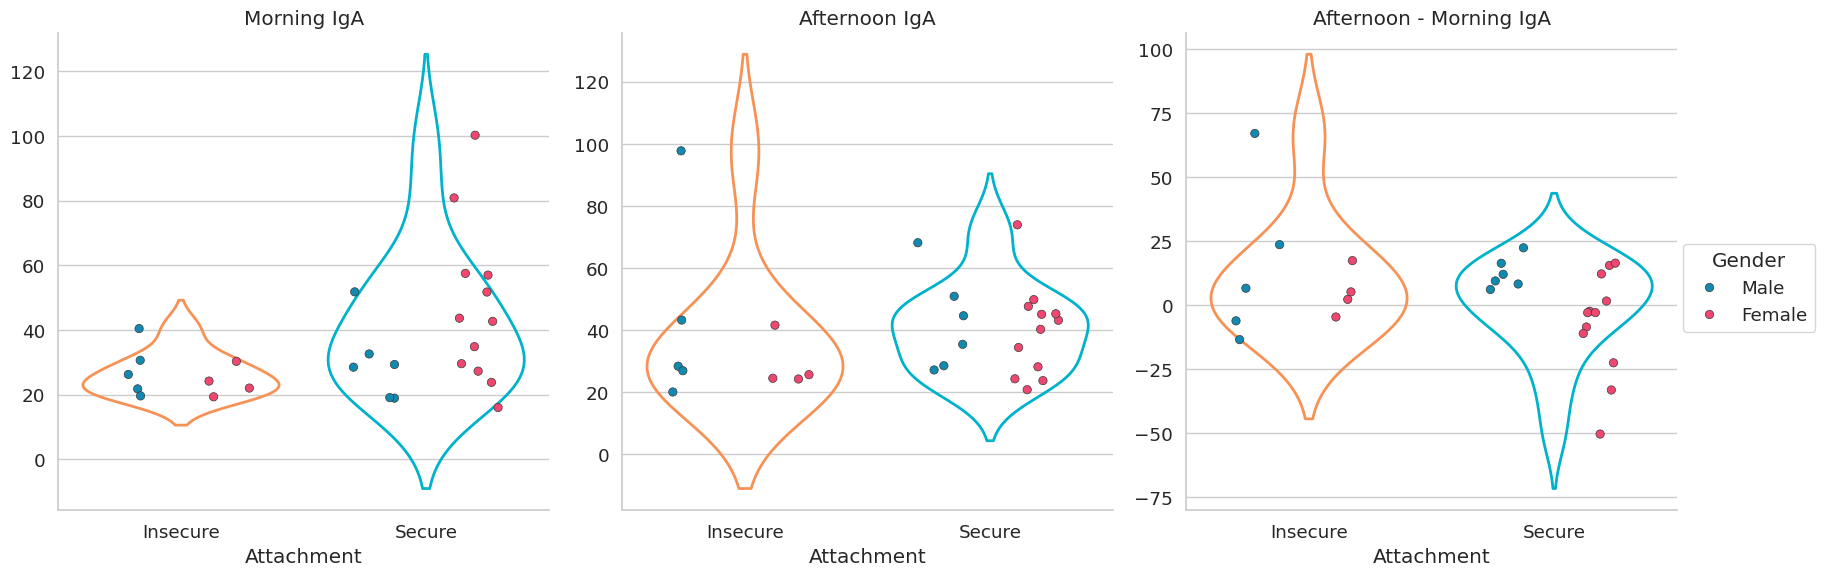

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
sns.set(style="whitegrid", font_scale=1.2)

variables = [
    "Average IgA Morning",
    "Average IgA Afternoon",
    "Average Difference IgA"
]

titles = [
    "Morning IgA",
    "Afternoon IgA",
    "Afternoon - Morning IgA"
]

for ax, var, title in zip(axes, variables, titles):
    # Violin plot
    sns.violinplot(
        data=df_data_clean,
        x="Attachment",
        y=var,
        inner=None,
        palette={"Secure": "#00B2CA", "Insecure": "#F79256"},
        linewidth=2,
        fill=False,
        ax=ax
    )

    # Stripplot (jitter individual points)
    sns.stripplot(
        data=df_data_clean,
        x="Attachment",
        y=var,
        hue="Gender",
        dodge=True,
        jitter=0.2,
        size=6,
        palette={"Male": "#118AB2", "Female": "#EF476F"},
        linewidth=0.5,
        edgecolor="gray",
        ax=ax
    )

    ax.set_title(title)
    ax.set_xlabel("Attachment")
    ax.set_ylabel("")
    ax.legend_.remove()

# Añadir leyenda común
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Gender", loc='center right', bbox_to_anchor=(1.02, 0.5))
sns.despine()
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

- Working with clustering and pattern recognition for profile generation. Manually with the following ranges:

| Range  | Category        | Justification                                                                                                       |
| ------ | -------------------- | ------------------------------------------------------------------------------------------------------------------- |
| `> 50` | **High variability** | It represents a significant change in daily concentration (>50 µg/mL), beyond the typical circadian variation. |
| `≤ 50` | **Low/Moderate**     | Changes that could be physiological, within the range expected under normal conditions.                           |


| Range    | Category    | Justification                                                                                                         |
| -------- | ---------------- | --------------------------------------------------------------------------------------------------------------------- |
| `< 30`   | **Low IgA**      | Consistently low values ​​in the sample possibly reflect immune suppression or specific conditions. |
| `30–100` | **Moderate IgA** | Central range of most subjects.                                                                           |
| `> 100`  | **High IgA**     | Less frequent elevated values ​​that could be biologically or clinically significant.                     |


In [67]:
df_data_clean.head(5)

,ID,Attachment,Gender,Average IgA Morning,Average IgA Afternoon,Average Difference IgA,Group
0,1,Insecure,Male,21.765240,28.368055,6.602815,Insecure - Male
1,4,Secure,Male,28.473065,50.881961,22.408896,Secure - Male
2,5,Secure,Female,100.215520,49.798129,-50.417391,Secure - Female
3,7,Insecure,Female,24.173487,41.577934,17.404447,Insecure - Female
5,12,Secure,Female,29.554870,45.078186,15.523316,Secure - Female


In [70]:
df_data_clean["Variability_Profile"] = df_data_clean["Average Difference IgA"].apply(
    lambda x: "High variability" if x > 50 else "Low/Moderate"
)

df_data_clean["IgA_Level_Profile_Morning"] = df_data_clean["Average IgA Morning"].apply(classify_iga_level)
df_data_clean["IgA_Level_Profile_Afternoon"] = df_data_clean["Average IgA Afternoon"].apply(classify_iga_level)
df_data_clean.head(5)


,ID,Attachment,Gender,Average IgA Morning,Average IgA Afternoon,Average Difference IgA,Group,Variability_Profile,IgA_Level_Profile_Morning,IgA_Level_Profile_Afternoon
0,1,Insecure,Male,21.765240,28.368055,6.602815,Insecure - Male,Low/Moderate,Low IgA,Low IgA
1,4,Secure,Male,28.473065,50.881961,22.408896,Secure - Male,Low/Moderate,Low IgA,Moderate IgA
2,5,Secure,Female,100.215520,49.798129,-50.417391,Secure - Female,Low/Moderate,High IgA,Moderate IgA
3,7,Insecure,Female,24.173487,41.577934,17.404447,Insecure - Female,Low/Moderate,Low IgA,Moderate IgA
5,12,Secure,Female,29.554870,45.078186,15.523316,Secure - Female,Low/Moderate,Low IgA,Moderate IgA


In [71]:
df_data_clean["Variability_Profile"].value_counts()

Low/Moderate        26
High variability     1
Name: Variability_Profile, dtype: int64

In [72]:
df_data_clean["IgA_Level_Profile_Morning"].value_counts()

Low IgA         14
Moderate IgA    12
High IgA         1
Name: IgA_Level_Profile_Morning, dtype: int64

In [73]:
df_data_clean["IgA_Level_Profile_Afternoon"].value_counts()

Moderate IgA    15
Low IgA         12
Name: IgA_Level_Profile_Afternoon, dtype: int64

- Checking changes

In [74]:
changing_data = []
for index in df_data_clean.index:
    change = ""
    morning = df_data_clean["IgA_Level_Profile_Morning"][index]
    afternoon = df_data_clean["IgA_Level_Profile_Afternoon"][index]

    if morning == afternoon:
        change = "No Change"
    elif (morning == "Low IgA" and afternoon in ["Moderate IgA", "High IgA"]) or (morning == "Moderate IgA" and afternoon == "High IgA"):
        change = "Increase"
    elif (morning == "Moderate IgA" and afternoon == "Low IgA") or (morning == "High IgA" and afternoon == "Moderate IgA"):
        change = "Decrease"
    else:
        change = "check"
    
    changing_data.append(change)

df_data_clean["IgA-Change"] = changing_data
df_data_clean["IgA-Change"].value_counts()
    

No Change    18
Increase      5
Decrease      4
Name: IgA-Change, dtype: int64

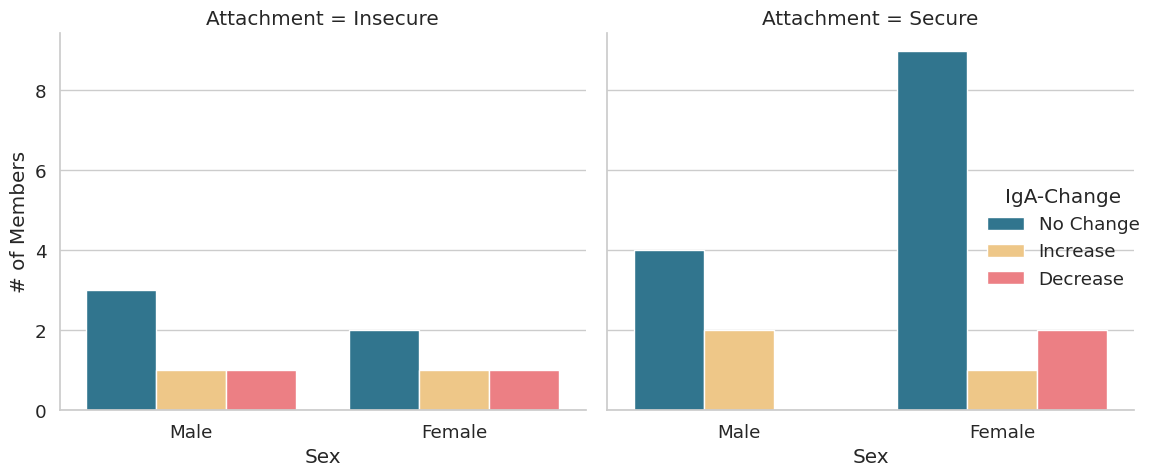

In [76]:
g = sns.catplot(
    data=df_data_clean,
    kind="count",
    x="Gender",
    hue="IgA-Change",
    col="Attachment",
    palette=["#227C9D", "#FFCB77", "#FE6D73"]
)

g.set_axis_labels("Sex", "# of Members")
g._legend.set_title("IgA-Change")
plt.tight_layout()
plt.show()


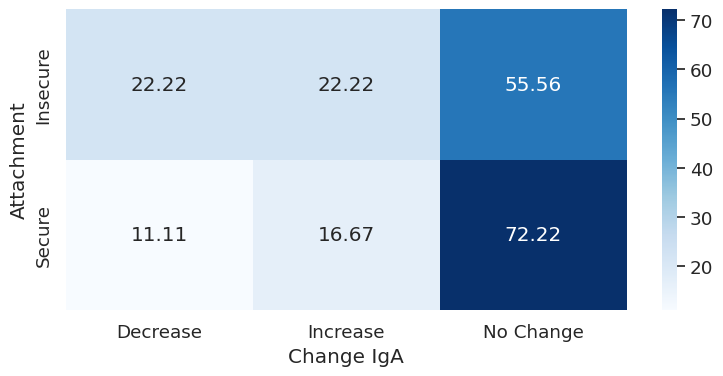

In [87]:
heat_data = pd.crosstab(df_data_clean["Attachment"], df_data_clean["IgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Attachment")
plt.xlabel("Change IgA")
plt.tight_layout()
plt.show()

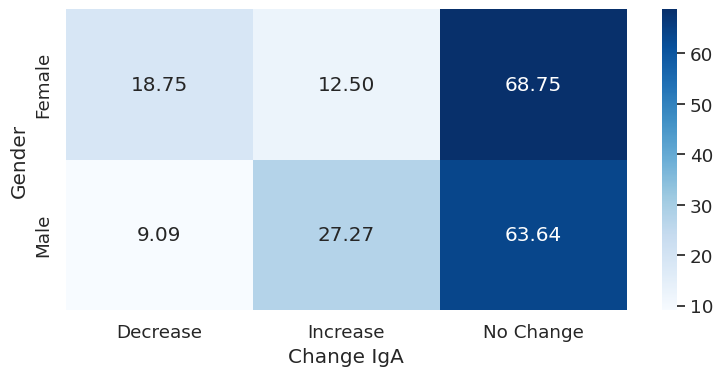

In [86]:
heat_data = pd.crosstab(df_data_clean["Gender"], df_data_clean["IgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Gender")
plt.xlabel("Change IgA")
plt.tight_layout()
plt.show()

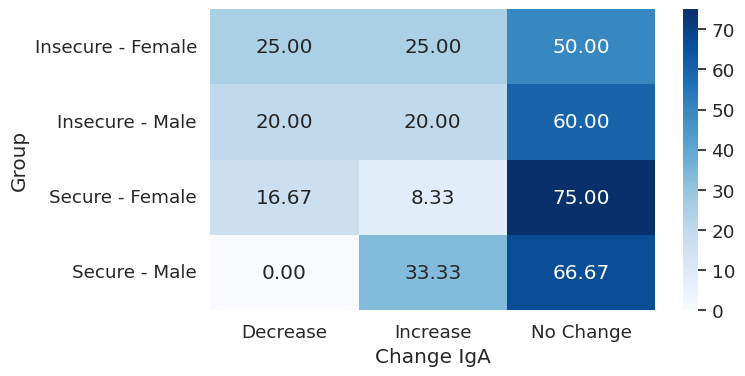

In [88]:
heat_data = pd.crosstab(df_data_clean["Group"], df_data_clean["IgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Group")
plt.xlabel("Change IgA")
plt.tight_layout()
plt.show()